In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


MJ dataset 위치 확인 옮기기

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ/MJ_test'

In [4]:
tf.__version__

'2.1.0'

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### 12-5. Recognition model (2) Input Image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


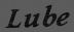

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


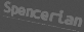

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


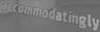

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


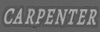

In [6]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


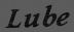

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


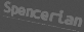

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


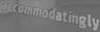

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


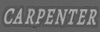

In [7]:
from IPython.display import display

env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32 )
        
        print('target_img_size:{}'.format(target_img_size))
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

대부분의 이미지의 height는 31, 최대 32까지로 되어 있고, width는 문자열 길이에 따라 다양한 것으로 보입니다.

우리는 lmdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스를 구현하려고 합니다. dataset_path는 읽어들일 데이터셋의 경로입니다. label_converter는 아래에서 여러분이 문자를 미리정의된 index로 변환해주는 converter로 직접 구현하도록 합니다. 이외에도 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있습니다.

In [8]:
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,
                      label_converter,
                      batch_size=1,
                      img_size=(100,32),
                      max_text_len=22,
                      is_train=False,
                      character=''
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    def _get_img_label(self, index):
        # Return image array and label in string
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width,self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

위의 분석코드처럼 이미지 데이터를 img, label의 쌍으로 가져오는 부분은 _get_img_label() 메소드에 반영되었습니다. 그리고 model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 _get_img_label() 를 통해 가져온 데이터셋을 리턴하게 될 것입니다. _get_img_label() 를 보면 다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있습니다.

## 12-6. Recognition model (3) Encode

 Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있었습니다. 이것은 모델을 학습하기 위해서 적절한 형태가 아닙니다. 따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 합니다. 이를 해줄 수 있는 LabelConverter 클래스를 작성해봅시다.



__init__() 에서는 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. decode는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.

encode를 모델이 학습할 수 있는 label로 만들 수 있도록 만들어주세요!



In [9]:
class LabelConverter(object):
     """ Convert between text-label and text-index """

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         # [[YOUR CODE]]
         for i, char in enumerate(text):
                if i > 0 and char == text[i - 1]:
                    encoded_label.append(0)
                encoded_label.append(self.label_map[char])

         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [10]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


## 12-7. Recognition model (4) Build CRNN model

이제 입력과 출력을 준비했으니 모델을 만들어볼 차례입니다. Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만들어두었습니다.

In [11]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

위 텐서플로우 튜토리얼에 따르면, K.ctc_batch_cost(y_true, y_pred, input_length, label_length)에는 4가지 인자가 존재합니다. 각각의 인자의 의미는 다음과 같습니다.

y_true: tensor (samples, max_string_length) containing the truth labels.

y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.


input_length tensor: (samples, 1) containing the sequence length for each batch item in y_pred.
label_length tensor: (samples, 1) containing the sequence length for each batch item in y_true.

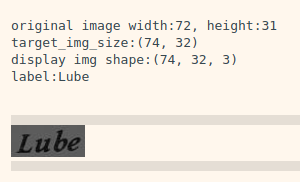

위 그림은 이전 스텝에서 살펴본 실제 데이터셋 예시입니다. 이 케이스를 예로 들었을 때 위 인자들은 다음과 같이 될 것입니다.

y_true: 실제 라벨 LUBE. 그러나 텍스트 라벨 그대로가 아니라, 각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정
y_pred: 우리가 만들 RCNN 모델의 출력 결과. 그러나 길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정
input_length tensor: 모델 입력 길이 T로서, 이 경우에는 텍스트의 width인 74
label_length tensor: 라벨의 실제 정답 길이 U로서, 이 경우에는 4

K.ctc_batch_cost()를 활용하여, image_input을 입력으로 그리고 마지막 Label을 'output'이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 build_crnn_model()을 구현해 봅시다.

In [12]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    # [[YOUR CODE]]
        # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    y_func = tf.keras.backend.function(image_input, [y_pred])
    return model, y_func

## 12-8. Recognition model (5) Train & Inference

MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습을 시켜봅시다. 우리는 시간이 많지 않으니 적절한 Epoch를 설정하여 모델을 학습시켜봅시다! 1Epoch에 10초 정도 소요될 것입니다.

In [13]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
        steps_per_epoch=len(val_set),
        epochs=30, #100,-> 30
        validation_data=val_set,
        validation_steps=len(val_set),
        callbacks=[ckp])

  {'ctc': '...'}
    to  
  ['...']
  {'ctc': '...'}
    to  
  ['...']
Train for 63 steps, validate for 63 steps
Epoch 1/30
62/63 [============================>.] - ETA: 0s - loss: 28.9869
Epoch 00001: val_loss improved from inf to 27.08924, saving model to /home/aiffel0042/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 35s 552ms/step - loss: 28.9622 - val_loss: 27.0892
Epoch 2/30
62/63 [============================>.] - ETA: 0s - loss: 26.5507
Epoch 00002: val_loss improved from 27.08924 to 26.26960, saving model to /home/aiffel0042/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 26s 409ms/step - loss: 26.5351 - val_loss: 26.2696
Epoch 3/30
62/63 [============================>.] - ETA: 0s - loss: 26.2863
Epoch 00003: val_loss improved from 26.26960 to 26.00863, saving model to /home/aiffel0042/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 26s 408ms/step - loss: 26.2891 - val_loss: 26.0086
Epoch 4/30
62/6

62/63 [============================>.] - ETA: 0s - loss: 5.9652
Epoch 00030: val_loss improved from 7.18346 to 6.58426, saving model to /home/aiffel0042/aiffel/ocr/model_checkpoint.hdf5
63/63 [==============================] - 26s 418ms/step - loss: 5.9658 - val_loss: 6.5843


Result: 	 SLINKING


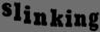

Result: 	 ALEPO


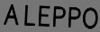

Result: 	 FWGNDE


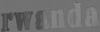

Result: 	 NATHANS


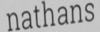

Result: 	 HALD


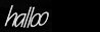

Result: 	 HUERIS


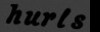

Result: 	 DOWNSIZE


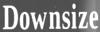

Result: 	 ROBOTIC


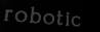

Result: 	 STOPY


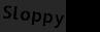

Result: 	 HERMITE


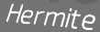

In [19]:
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model, test_set, index=10)

In [20]:
from keras_ocr.detection import Detector
SAMPLE_IMG_PATH = 'sample.jpg'
detector = Detector()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5


이미지 경로를 받아 해당 이미지 내의 문자를 찾아내는 함수를 keras-ocr의 Detector를 이용해서 만들어보세요! inference한 후에는 이를 시각화하도록 합니다. 그리고 단어의 영역을 잘라오도록 해주세요.

In [21]:
import keras_ocr
def detect_text(img_path):
    pipeline = keras_ocr.pipeline.Pipeline()
    
    images = keras_ocr.tools.read(img_path)
    predictions = pipeline.recognize([img_path])
    
    result_img = keras_ocr.tools.drawAnnotations(image=images, predictions=predictions[0])

    cropped_imgs = []
    revised_boxes = []
    for _, box in predictions[0]:
        revised_boxes.append(box)
    boxes = revised_boxes

    crop_box =[]
    for box in boxes:
        cropped_imgs.append(keras_ocr.tools.warpBox(image=images, box=box))
    
    
#     # TODO
    
#         # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.

#         # 배치의 첫 번째 결과만 가져옵니다.

#         # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)

#         cropped_imgs = []
#         for text_result in ocr_result:
#             img_draw.polygon(text_result, outline='red')
#             x_min = text_result[:,0].min() - 5
#             x_max = text_result[:,0].max() + 5
#             y_min = text_result[:,1].min() - 5
#             y_max = text_result[:,1].max() + 5
#             word_box = [x_min, y_min, x_max, y_max]
#             cropped_imgs.append(img_pil.crop(word_box))

#         img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
#         display(img_pil)

        return result_img, cropped_imgs

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel0042/.keras-ocr/crnn_kurapan.h5


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


<AxesSubplot:>

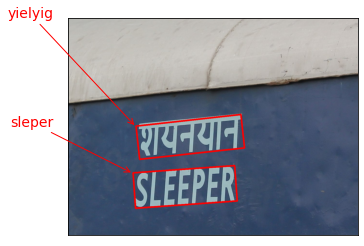

In [22]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

### 시각화

IndexError: list index out of range

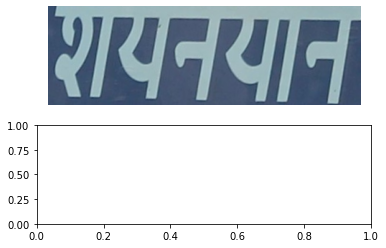

In [23]:
import matplotlib.pyplot as plt 

plt.subplot(2, 1, 1)
plt.imshow(cropped_img[0])
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(cropped_img[1])
plt.axis('off')

In [24]:
def recognize_img(pil_img, input_img_size=(100,32)):
    img90 = cv2.rotate(pil_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    img_flip = cv2.flip(img90, 0)
    pil_img = cv2.resize(img_flip, (32, 100), interpolation = cv2.INTER_CUBIC)
    
    img = pil_img.reshape(1, 100, 32, 3)
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    
    print("Result: \t", result)
    display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

In [25]:
 for _img in cropped_img:
    recognize_img(_img)

NameError: name 'cv2' is not defined